# DCGAN —— Conditional V1
V1指的是一起训练。

有一说一这个DCGAN真的太难训练了啊

我使用的Trick
- Soft label
- 数据的均值和标准差不能用实际的值，而是要用0.5 why？

# Import Necessary Packages

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import random

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets
from torchvision import transforms # 张量变换
from torchvision.utils import save_image # 保存图片

from itertools import product # draw 10 * 10 images
from tqdm import tqdm

import matplotlib.pyplot as plt
# Enable Jupyter notebook plotting
%matplotlib inline

# Pytorch Version
print(torch.__version__)
print(torch.cuda.is_available())

1.7.0
True


# Hyper Parameters

In [2]:
cudnn.benchmark = True

#set manual seed to a constant get a consistent output
manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

batch_size = 256
num_epoch = 50

ngf = 64  # base dimesion of G's feature
ndf = 64 # base dimesion of D's feature
z_dim = 100 # size of input noise's channel
embedding_dim = 10 # size of conditional embedding for both G & D

nc = 3 # channels of output images

lr_G = 2e-4
lr_D = 2e-4 # leanring rate of Generator and Discriminator


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Random Seed:  6853
cuda:0


# Datasets files & utils

In [3]:
# the path we save data
if not os.path.exists('../../img'):
    os.mkdir('../../img')

# Transform of our datasets
trans = transforms.Compose([transforms.RandomResizedCrop(32, scale=(0.9, 1.0), ratio=(0.9, 1.1), interpolation=2),
                            transforms.RandomHorizontalFlip(p=0.5), # 30% 概率水平翻转
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                            ])
    
# CIFAR10 datasets downloading……
cifar10 = datasets.CIFAR10(
    root = '../../data/cifar10/', train = True, transform = trans, download = True
)

# Dataloader
dataloader = torch.utils.data.DataLoader(
    dataset = cifar10, batch_size = batch_size, shuffle = True, num_workers = 8,
)



Files already downloaded and verified


In [4]:
inv_normalize = transforms.Normalize(
    mean=[-0.5/0.5, -0.5/0.5, -0.5/0.5],
    std=[1/0.5, 1/0.5, 1/0.5]
)
# inv_tensor = inv_normalize(tensor)



# Discriminator Definitions (Conditional DCGAN Fashion)
As mentioned, the discriminator, $D$, is a binary classification network that takes an image as input and outputs a scalar probability that the input image is real (as opposed to fake).

Here, $D$ takes a 3x64x64 input image, processes it through a series of Conv2d, BatchNorm2d, and LeakyReLU layers, and outputs the final probability through a Sigmoid activation function. 

This architecture can be extended with more layers if necessary for the problem, but there is significance to the use of the strided convolution, BatchNorm, and LeakyReLUs. 
The DCGAN paper mentions it is a good practice to use strided convolution rather than pooling to downsample because it lets the network learn its own pooling function. Also batch norm and leaky relu functions promote healthy gradient flow which is critical for the learning process of both $G$ and $D$.

It is a **conditional** version, it'

In [5]:

class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.D_conv = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, kernel_size = 4,
                      stride = 2, padding = 1),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 18
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4 ,ndf * 4, 4, 1, 0, bias=False),
        )
        self.D_embedding = nn.Embedding(num_embeddings = 10, embedding_dim = embedding_dim, ) 
        self.D_out = nn.Sequential(
            nn.Conv2d(ndf * 4 + embedding_dim, embedding_dim + 1 , 1, 1, 0, bias=False),
            nn.BatchNorm2d(embedding_dim + 1 ),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(embedding_dim + 1 , 1, 1, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x,c):
        x = self.D_conv(x)
        x_c = self.D_embedding(c).view(-1, embedding_dim, 1, 1)
        x_c = torch.cat((x, x_c), 1)
        out = self.D_out(x_c)
        return out

# Generator Definitions (Vanilla DCGAN Fashion)
The generator, $G$, is designed to map the latent space vector $(z)$ to data-space. Since our data are images, converting z to data-space means ultimately creating a RGB image with the same size as the training images (i.e. 3x64x64). In practice, this is accomplished through a series of strided two dimensional convolutional transpose layers, each paired with a 2d batch norm layer and a relu activation. The output of the generator is fed through a tanh function to return it to the input data range of $[−1,1]$. It is worth noting the existence of the batch norm functions after the conv-transpose layers, as this is a critical contribution of the DCGAN paper. These layers help with the flow of gradients during training. An image of the generator from the DCGAN paper is shown below.

The generator, G, is designed to map the latent space vector $(z)$ to data-space. Since our data are images, converting z to data-space means ultimately creating a RGB image with the same size as the training images (i.e. 3x64x64). In practice, this is accomplished through a series of strided two dimensional convolutional transpose layers, each paired with a 2d batch norm layer and a relu activation. The output of the generator is fed through a tanh function to return it to the input data range of $[−1,1]$. It is worth noting the existence of the batch norm functions after the conv-transpose layers, as this is a critical contribution of the DCGAN paper. These layers help with the flow of gradients during training. An image of the generator from the DCGAN paper is shown below.

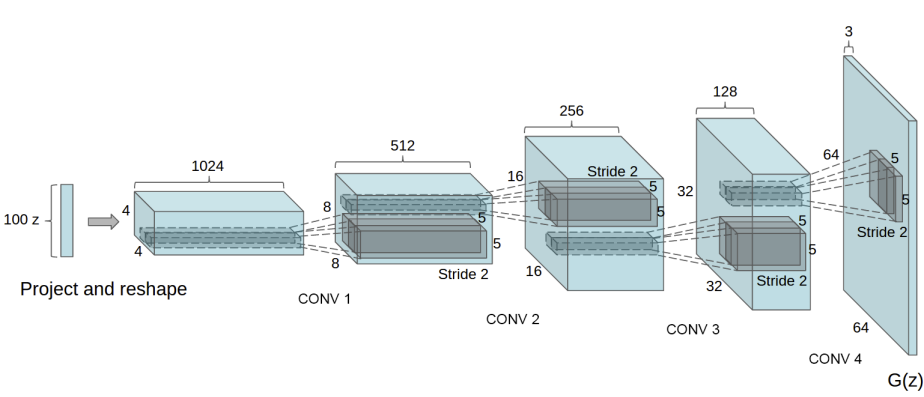

The final `Tanh` activataion function can project output into (-1,1)

Notice, the how the inputs we set in the input section (z_dim, ngf, and nc) influence the generator architecture in code.  is the length of the z input vector, ngf relates to the size of the feature maps that are propagated through the generator, and nc is the number of channels in the output image (set to 3 for RGB images). Below is the code for the generator.


It is a **conditional** version.

In [6]:

class generator(nn.Module):
    
    def __init__(self):
        super(generator, self).__init__()
        self.G = nn.Sequential(
            nn.ConvTranspose2d(z_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4,
                              stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4,
                              stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, nc, kernel_size=4,
                              stride=2, padding=1, bias=False),
            # state size. nc x 32 x 32            
            nn.Tanh()
            )
        self.G_embedding = nn.Embedding(num_embeddings = 10, embedding_dim = embedding_dim, ) 
        
    def forward(self, x, c):
        x_c = self.G_embedding(c).view(-1, embedding_dim, 1, 1)
        x = torch.cat((x, x_c), 1)
        x = self.G(x)
        return x
        
        

## Weight Initialization
From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.



In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Traning Phase
## Model & Opitmizer

In [8]:


D = discriminator()
G = generator()
D.apply(weights_init)
G.apply(weights_init)
# TODO: 自定义初始化

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

D = D.to(device)
G = G.to(device)




In [9]:
criterion = nn.BCELoss() # 二分类交叉熵

d_optimizer = torch.optim.Adam(D.parameters(), lr = lr_D, betas=(0.5,0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr = lr_G, betas=(0.5,0.999))

## Trainning Start!

In [10]:
G_losses = []
D_losses = []
Miss_real = []
Match_fake = []

for epoch in tqdm(range(num_epoch)):
    for i, (img, condition) in enumerate(dataloader): # Since we don't need any labels, we make label be '_'

        # =============================== IMAGES =================================
        num_img = img.size(0) 
        #img = img.view(num_img, -1) # view()函数作用是将一个多行的Tensor,拼接成一行
                                    # 第一个参数是要拼接的tensor,第二个参数是-1
        # After view(), the input image will be a vector as 28 * 28 = 782 dimensions
        real_img = img.to(device) # the sampled data are real images
        condition = condition.to(device)
        # =============================== LABELS =================================
        real_label = (torch.ones(num_img) - 0.1).view(-1, 1).to(device) # Label of real images is 1
        fake_label = (torch.zeros(num_img) + 0.1).view(-1, 1).to(device) # label of real images is 0
        miss_label = torch.zeros(num_img).view(-1, 1).to(device)
        # ========================= D: Forward and Loss ==========================
        # Real Image, matched label(contidion)
        real_out = D(real_img, condition)
        
        d_loss_real = criterion(real_out.view(-1,1), real_label) # TODO: criterion

        
        # Fake Image, excepted matched label(condition)
        z = torch.randn(num_img, z_dim - embedding_dim, 1, 1).to(device)
        c = torch.randint(low = 0, high = 9, size = (num_img,)).to(device)
        fake_img = G(z, c)
        
        fake_out = D(fake_img, c) 
        d_loss_fake = criterion(fake_out.view(-1,1), fake_label)
        
        # Real Image, MISSMATCHED label(condition)
        shuffle = torch.randint(low = 1, high = 9, size = (num_img, ))%9
        shuffle = shuffle.to(device)
        condition_shuffle = (condition + shuffle)%9
        miss_out = D(real_img, condition_shuffle) 
        d_loss_miss = criterion(miss_out.view(-1, 1), miss_label)
        
        d_loss = d_loss_real + d_loss_fake + d_loss_miss
        
        d_optimizer.zero_grad() # before back propagation
        d_loss.backward()
        d_optimizer.step()
        
        
        
        # =============== G ========================
        # To fool the Discriminator, we want G's fake output can get 'real' pridection
        z = torch.randn(num_img, z_dim - embedding_dim, 1, 1).to(device)
        c = torch.randint(low = 0, high = 9, size = (num_img,)).to(device)
        # z = torch.randn(num_img, z_dim, 1, 1)
        
        fake_img = G(z, c)
        fake_out = D(fake_img, c)
        g_loss = criterion(fake_out.view(-1, 1), real_label)
        real_g_loss = g_loss
        
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        # ============= Visualization ===============
        D_losses.append(d_loss)
        G_losses.append(real_g_loss)
        if i%100 == 0:
            print('Epoch[{}/{}],d_loss:{:.4f},g_loss:{:.4f} '
                  'D real: {:.4f},D fake: {:.4f}, D miss:{:.4f}, '.format(
                epoch,num_epoch,d_loss.item(),real_g_loss.item(),
                real_out.data.mean(),fake_out.data.mean(),miss_out.data.mean()  #打印的是真实图片的损失均值
            ))
        
    if epoch == 0:
        real_images = inv_normalize(real_img.cpu().data)
        save_image(real_images, '../../img/CV1/real_images.png')
 
    fake_images = inv_normalize(fake_img.cpu().data)
    save_image(fake_images, '../../img/CV1/V1fake_images-{}.png'.format(epoch+1))

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch[0/50],d_loss:2.0873,g_loss:0.6876 D real: 0.5035,D fake: 0.5036, D miss:0.5036, 
Epoch[0/50],d_loss:2.0510,g_loss:0.7174 D real: 0.4838,D fake: 0.4852, D miss:0.4838, 


  2%|▏         | 1/50 [00:16<13:27, 16.48s/it]

Epoch[1/50],d_loss:2.0183,g_loss:0.7500 D real: 0.4633,D fake: 0.4661, D miss:0.4632, 
Epoch[1/50],d_loss:1.9883,g_loss:0.7882 D real: 0.4436,D fake: 0.4449, D miss:0.4435, 


  4%|▍         | 2/50 [00:32<12:57, 16.21s/it]

Epoch[2/50],d_loss:1.9615,g_loss:0.8286 D real: 0.4331,D fake: 0.4238, D miss:0.4329, 
Epoch[2/50],d_loss:1.9317,g_loss:0.8820 D real: 0.4170,D fake: 0.3974, D miss:0.4166, 


  6%|▌         | 3/50 [00:48<12:51, 16.41s/it]

Epoch[3/50],d_loss:1.8945,g_loss:0.9431 D real: 0.4139,D fake: 0.3694, D miss:0.4099, 
Epoch[3/50],d_loss:1.9011,g_loss:0.9731 D real: 0.3669,D fake: 0.3564, D miss:0.3602, 


  8%|▊         | 4/50 [01:06<12:56, 16.89s/it]

Epoch[4/50],d_loss:1.9076,g_loss:0.9665 D real: 0.3759,D fake: 0.3594, D miss:0.3709, 
Epoch[4/50],d_loss:1.8882,g_loss:1.0160 D real: 0.3542,D fake: 0.3390, D miss:0.3429, 


 10%|█         | 5/50 [01:24<12:51, 17.15s/it]

Epoch[5/50],d_loss:1.8618,g_loss:1.0615 D real: 0.3782,D fake: 0.3224, D miss:0.3629, 
Epoch[5/50],d_loss:1.8343,g_loss:1.1161 D real: 0.3676,D fake: 0.3021, D miss:0.3545, 


 12%|█▏        | 6/50 [01:40<12:18, 16.78s/it]

Epoch[6/50],d_loss:1.8512,g_loss:1.0677 D real: 0.3598,D fake: 0.3193, D miss:0.3381, 
Epoch[6/50],d_loss:1.8309,g_loss:1.0944 D real: 0.3590,D fake: 0.3095, D miss:0.3341, 


 14%|█▍        | 7/50 [01:55<11:43, 16.35s/it]

Epoch[7/50],d_loss:1.8839,g_loss:1.1041 D real: 0.3329,D fake: 0.3070, D miss:0.3141, 
Epoch[7/50],d_loss:1.8363,g_loss:1.1319 D real: 0.3660,D fake: 0.2973, D miss:0.3379, 


 16%|█▌        | 8/50 [02:11<11:21, 16.22s/it]

Epoch[8/50],d_loss:1.8672,g_loss:1.0954 D real: 0.3258,D fake: 0.3099, D miss:0.3016, 
Epoch[8/50],d_loss:1.8768,g_loss:1.1565 D real: 0.3470,D fake: 0.2899, D miss:0.3153, 


 18%|█▊        | 9/50 [02:26<10:50, 15.88s/it]

Epoch[9/50],d_loss:1.8658,g_loss:1.0235 D real: 0.3503,D fake: 0.3370, D miss:0.3252, 
Epoch[9/50],d_loss:1.8457,g_loss:1.1335 D real: 0.3374,D fake: 0.2966, D miss:0.3051, 


 20%|██        | 10/50 [02:43<10:44, 16.11s/it]

Epoch[10/50],d_loss:1.8961,g_loss:1.1534 D real: 0.3231,D fake: 0.2912, D miss:0.2964, 
Epoch[10/50],d_loss:1.8512,g_loss:1.1001 D real: 0.3394,D fake: 0.3087, D miss:0.3037, 


 22%|██▏       | 11/50 [03:00<10:33, 16.24s/it]

Epoch[11/50],d_loss:1.8562,g_loss:1.0407 D real: 0.3421,D fake: 0.3308, D miss:0.3068, 
Epoch[11/50],d_loss:1.8529,g_loss:1.0787 D real: 0.3496,D fake: 0.3164, D miss:0.3092, 


 24%|██▍       | 12/50 [03:16<10:14, 16.16s/it]

Epoch[12/50],d_loss:1.8595,g_loss:1.0575 D real: 0.3512,D fake: 0.3239, D miss:0.3131, 
Epoch[12/50],d_loss:1.8560,g_loss:1.0890 D real: 0.3457,D fake: 0.3142, D miss:0.3156, 


 26%|██▌       | 13/50 [03:31<09:47, 15.88s/it]

Epoch[13/50],d_loss:1.7913,g_loss:1.0234 D real: 0.3686,D fake: 0.3370, D miss:0.3247, 
Epoch[13/50],d_loss:1.8381,g_loss:0.9964 D real: 0.3502,D fake: 0.3477, D miss:0.3082, 


 28%|██▊       | 14/50 [03:47<09:31, 15.87s/it]

Epoch[14/50],d_loss:1.8615,g_loss:1.0658 D real: 0.3292,D fake: 0.3221, D miss:0.2914, 
Epoch[14/50],d_loss:1.8558,g_loss:1.0512 D real: 0.3443,D fake: 0.3286, D miss:0.3010, 


 30%|███       | 15/50 [04:03<09:25, 16.15s/it]

Epoch[15/50],d_loss:1.8571,g_loss:1.0604 D real: 0.3366,D fake: 0.3235, D miss:0.2990, 
Epoch[15/50],d_loss:1.8142,g_loss:1.0971 D real: 0.3519,D fake: 0.3117, D miss:0.3048, 


 32%|███▏      | 16/50 [04:23<09:46, 17.25s/it]

Epoch[16/50],d_loss:1.8185,g_loss:1.0782 D real: 0.3527,D fake: 0.3176, D miss:0.3079, 
Epoch[16/50],d_loss:1.8160,g_loss:1.1061 D real: 0.3382,D fake: 0.3083, D miss:0.2878, 


 34%|███▍      | 17/50 [04:42<09:47, 17.80s/it]

Epoch[17/50],d_loss:1.8575,g_loss:1.0213 D real: 0.3423,D fake: 0.3389, D miss:0.2866, 
Epoch[17/50],d_loss:1.8222,g_loss:1.1095 D real: 0.3337,D fake: 0.3092, D miss:0.2805, 


 36%|███▌      | 18/50 [05:01<09:38, 18.07s/it]

Epoch[18/50],d_loss:1.8250,g_loss:1.0094 D real: 0.3904,D fake: 0.3441, D miss:0.3279, 
Epoch[18/50],d_loss:1.8363,g_loss:1.1170 D real: 0.3445,D fake: 0.3041, D miss:0.2852, 


 38%|███▊      | 19/50 [05:16<08:48, 17.06s/it]

Epoch[19/50],d_loss:1.8322,g_loss:1.0780 D real: 0.3255,D fake: 0.3198, D miss:0.2726, 
Epoch[19/50],d_loss:1.8416,g_loss:1.1214 D real: 0.3331,D fake: 0.3032, D miss:0.2780, 


 40%|████      | 20/50 [05:33<08:37, 17.24s/it]

Epoch[20/50],d_loss:1.7855,g_loss:1.0806 D real: 0.3758,D fake: 0.3178, D miss:0.3076, 
Epoch[20/50],d_loss:1.7002,g_loss:1.0641 D real: 0.3751,D fake: 0.3245, D miss:0.2946, 


 42%|████▏     | 21/50 [05:51<08:25, 17.44s/it]

Epoch[21/50],d_loss:1.7848,g_loss:1.1107 D real: 0.3685,D fake: 0.3084, D miss:0.2970, 
Epoch[21/50],d_loss:1.8278,g_loss:1.0213 D real: 0.3802,D fake: 0.3393, D miss:0.3207, 


 44%|████▍     | 22/50 [06:08<07:57, 17.05s/it]

Epoch[22/50],d_loss:1.8098,g_loss:1.0118 D real: 0.3989,D fake: 0.3454, D miss:0.3339, 
Epoch[22/50],d_loss:1.7387,g_loss:1.2638 D real: 0.3873,D fake: 0.2586, D miss:0.3121, 


 46%|████▌     | 23/50 [06:24<07:33, 16.80s/it]

Epoch[23/50],d_loss:1.8167,g_loss:1.1060 D real: 0.3617,D fake: 0.3090, D miss:0.2724, 
Epoch[23/50],d_loss:1.7800,g_loss:1.0994 D real: 0.3973,D fake: 0.3100, D miss:0.3168, 


 48%|████▊     | 24/50 [06:38<06:58, 16.11s/it]

Epoch[24/50],d_loss:1.7836,g_loss:1.1974 D real: 0.3735,D fake: 0.2816, D miss:0.2670, 
Epoch[24/50],d_loss:1.7708,g_loss:1.1390 D real: 0.3548,D fake: 0.2995, D miss:0.2659, 


 50%|█████     | 25/50 [06:54<06:42, 16.11s/it]

Epoch[25/50],d_loss:1.7275,g_loss:1.1347 D real: 0.4113,D fake: 0.3014, D miss:0.3228, 
Epoch[25/50],d_loss:1.7246,g_loss:1.0519 D real: 0.3694,D fake: 0.3299, D miss:0.2726, 


 52%|█████▏    | 26/50 [07:16<07:03, 17.65s/it]

Epoch[26/50],d_loss:1.7906,g_loss:1.1687 D real: 0.3613,D fake: 0.2911, D miss:0.2653, 
Epoch[26/50],d_loss:1.8224,g_loss:0.9484 D real: 0.3358,D fake: 0.3722, D miss:0.2456, 


 54%|█████▍    | 27/50 [07:35<06:57, 18.17s/it]

Epoch[27/50],d_loss:1.7370,g_loss:1.2532 D real: 0.3671,D fake: 0.2635, D miss:0.2829, 
Epoch[27/50],d_loss:1.7443,g_loss:1.2274 D real: 0.4121,D fake: 0.2779, D miss:0.2955, 


 56%|█████▌    | 28/50 [07:53<06:35, 17.99s/it]

Epoch[28/50],d_loss:1.7393,g_loss:1.1291 D real: 0.3711,D fake: 0.3046, D miss:0.3025, 
Epoch[28/50],d_loss:1.9201,g_loss:0.8502 D real: 0.2903,D fake: 0.4160, D miss:0.1946, 


 58%|█████▊    | 29/50 [08:10<06:16, 17.94s/it]

Epoch[29/50],d_loss:1.7956,g_loss:0.8260 D real: 0.4413,D fake: 0.4281, D miss:0.3439, 
Epoch[29/50],d_loss:1.7145,g_loss:0.9932 D real: 0.3853,D fake: 0.3558, D miss:0.2677, 


 60%|██████    | 30/50 [08:25<05:37, 16.88s/it]

Epoch[30/50],d_loss:1.7347,g_loss:1.1618 D real: 0.3760,D fake: 0.2909, D miss:0.2601, 
Epoch[30/50],d_loss:1.7223,g_loss:1.0005 D real: 0.3718,D fake: 0.3516, D miss:0.2623, 


 62%|██████▏   | 31/50 [08:41<05:14, 16.56s/it]

Epoch[31/50],d_loss:1.7356,g_loss:0.9518 D real: 0.4491,D fake: 0.3735, D miss:0.3247, 
Epoch[31/50],d_loss:1.6736,g_loss:1.2256 D real: 0.4155,D fake: 0.2741, D miss:0.2914, 


 64%|██████▍   | 32/50 [08:57<04:57, 16.52s/it]

Epoch[32/50],d_loss:1.8061,g_loss:0.9910 D real: 0.4447,D fake: 0.3558, D miss:0.3139, 
Epoch[32/50],d_loss:1.6824,g_loss:1.2388 D real: 0.4248,D fake: 0.2724, D miss:0.2829, 


 66%|██████▌   | 33/50 [09:15<04:49, 17.05s/it]

Epoch[33/50],d_loss:1.8139,g_loss:1.2945 D real: 0.4098,D fake: 0.2547, D miss:0.2893, 
Epoch[33/50],d_loss:1.7249,g_loss:1.0248 D real: 0.3745,D fake: 0.3430, D miss:0.2650, 


 68%|██████▊   | 34/50 [09:32<04:32, 17.06s/it]

Epoch[34/50],d_loss:1.8749,g_loss:0.9153 D real: 0.4027,D fake: 0.3909, D miss:0.3052, 
Epoch[34/50],d_loss:1.7545,g_loss:1.1341 D real: 0.3966,D fake: 0.3037, D miss:0.2764, 


 70%|███████   | 35/50 [09:50<04:16, 17.13s/it]

Epoch[35/50],d_loss:1.8742,g_loss:0.7774 D real: 0.4379,D fake: 0.4542, D miss:0.3291, 
Epoch[35/50],d_loss:1.6312,g_loss:1.1909 D real: 0.4235,D fake: 0.2841, D miss:0.3076, 


 72%|███████▏  | 36/50 [10:04<03:47, 16.25s/it]

Epoch[36/50],d_loss:1.6803,g_loss:1.1936 D real: 0.3754,D fake: 0.2899, D miss:0.2403, 
Epoch[36/50],d_loss:1.9622,g_loss:0.8000 D real: 0.2901,D fake: 0.4431, D miss:0.1901, 


 74%|███████▍  | 37/50 [10:20<03:31, 16.29s/it]

Epoch[37/50],d_loss:1.7154,g_loss:1.2132 D real: 0.3626,D fake: 0.2830, D miss:0.2361, 
Epoch[37/50],d_loss:1.7052,g_loss:1.1904 D real: 0.3880,D fake: 0.2849, D miss:0.2727, 


 76%|███████▌  | 38/50 [10:37<03:17, 16.49s/it]

Epoch[38/50],d_loss:1.7500,g_loss:0.9388 D real: 0.4243,D fake: 0.3802, D miss:0.2758, 
Epoch[38/50],d_loss:1.5908,g_loss:1.4131 D real: 0.4314,D fake: 0.2274, D miss:0.2582, 


 78%|███████▊  | 39/50 [10:56<03:07, 17.06s/it]

Epoch[39/50],d_loss:1.6595,g_loss:1.0709 D real: 0.4204,D fake: 0.3286, D miss:0.2768, 
Epoch[39/50],d_loss:1.7088,g_loss:0.8947 D real: 0.3789,D fake: 0.3996, D miss:0.2366, 


 80%|████████  | 40/50 [11:16<02:59, 17.93s/it]

Epoch[40/50],d_loss:1.8087,g_loss:0.8878 D real: 0.4093,D fake: 0.3994, D miss:0.2732, 
Epoch[40/50],d_loss:1.6716,g_loss:1.6137 D real: 0.3746,D fake: 0.1877, D miss:0.2229, 


 82%|████████▏ | 41/50 [11:31<02:34, 17.13s/it]

Epoch[41/50],d_loss:1.6906,g_loss:1.1573 D real: 0.4136,D fake: 0.3038, D miss:0.3047, 
Epoch[41/50],d_loss:1.6879,g_loss:1.1451 D real: 0.3844,D fake: 0.3029, D miss:0.2468, 


 84%|████████▍ | 42/50 [11:47<02:13, 16.73s/it]

Epoch[42/50],d_loss:1.7040,g_loss:1.1629 D real: 0.4432,D fake: 0.3010, D miss:0.2664, 
Epoch[42/50],d_loss:1.6118,g_loss:1.3212 D real: 0.4825,D fake: 0.2602, D miss:0.3219, 


 86%|████████▌ | 43/50 [12:03<01:57, 16.76s/it]

Epoch[43/50],d_loss:1.6645,g_loss:1.0336 D real: 0.3674,D fake: 0.3442, D miss:0.2085, 
Epoch[43/50],d_loss:1.6648,g_loss:1.1303 D real: 0.3652,D fake: 0.3092, D miss:0.1863, 


 88%|████████▊ | 44/50 [12:20<01:40, 16.68s/it]

Epoch[44/50],d_loss:1.6677,g_loss:1.1046 D real: 0.3868,D fake: 0.3130, D miss:0.2441, 
Epoch[44/50],d_loss:1.7781,g_loss:1.1989 D real: 0.4979,D fake: 0.2875, D miss:0.3451, 


 90%|█████████ | 45/50 [12:37<01:24, 16.86s/it]

Epoch[45/50],d_loss:1.6766,g_loss:1.0876 D real: 0.3880,D fake: 0.3263, D miss:0.2315, 
Epoch[45/50],d_loss:1.6669,g_loss:1.1103 D real: 0.4875,D fake: 0.3169, D miss:0.3222, 


 92%|█████████▏| 46/50 [12:53<01:06, 16.53s/it]

Epoch[46/50],d_loss:1.6880,g_loss:1.1582 D real: 0.4352,D fake: 0.3020, D miss:0.2554, 
Epoch[46/50],d_loss:1.8161,g_loss:0.9151 D real: 0.3324,D fake: 0.3900, D miss:0.1741, 


 94%|█████████▍| 47/50 [13:08<00:48, 16.06s/it]

Epoch[47/50],d_loss:1.6408,g_loss:1.2035 D real: 0.4404,D fake: 0.2860, D miss:0.2462, 
Epoch[47/50],d_loss:1.7172,g_loss:1.1946 D real: 0.3970,D fake: 0.2868, D miss:0.2217, 


 96%|█████████▌| 48/50 [13:23<00:31, 15.68s/it]

Epoch[48/50],d_loss:1.6906,g_loss:1.0841 D real: 0.4891,D fake: 0.3324, D miss:0.3041, 
Epoch[48/50],d_loss:1.6005,g_loss:1.2113 D real: 0.4670,D fake: 0.2863, D miss:0.2648, 


 98%|█████████▊| 49/50 [13:42<00:16, 16.84s/it]

Epoch[49/50],d_loss:1.6043,g_loss:1.0682 D real: 0.3934,D fake: 0.3323, D miss:0.2125, 
Epoch[49/50],d_loss:1.6207,g_loss:1.1062 D real: 0.4170,D fake: 0.3147, D miss:0.2313, 


100%|██████████| 50/50 [14:01<00:00, 16.84s/it]


# Visualization

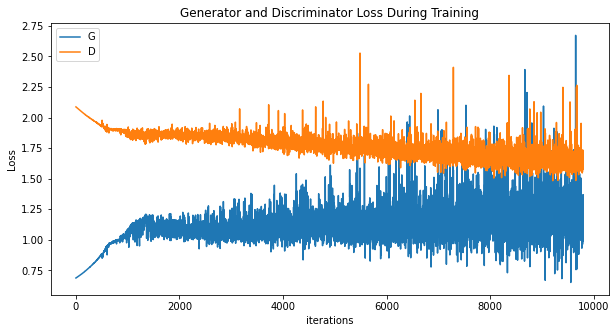

In [11]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [12]:
if not os.path.exists('../../img/CV1/conditional'):
    os.mkdir('../../img/CV1/conditional')

for i in range(10):
    c = torch.randint(low = 0, high = 9, size = (num_img,)).to(device)
    c = c * 0 + i
    z = torch.randn(num_img, z_dim - embedding_dim, 1, 1).to(device)
    conditional_img = G(z, c)    
    conditional_img = inv_normalize(conditional_img.cpu().data)
    save_image(conditional_img, '../../img/CV1/conditional/V1Condtional_fake_images-{}.png'.format(i))

# 可视化结论
## 1. 飞机
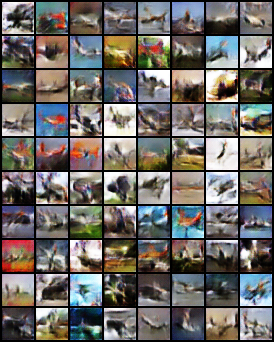
## 2. 小汽车
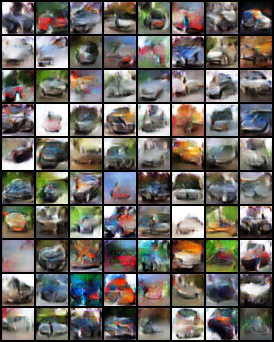
## 3. 鸟
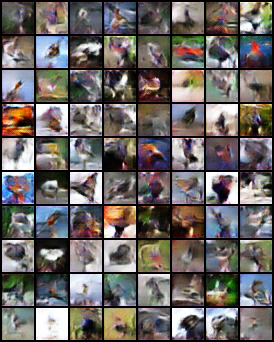
## 4. 猫
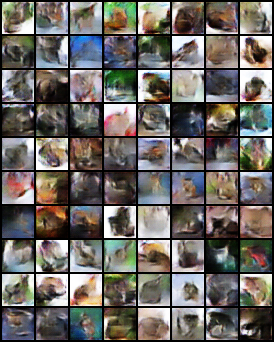
## 5. 鹿
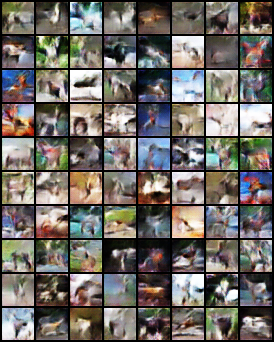
## 6. 狗
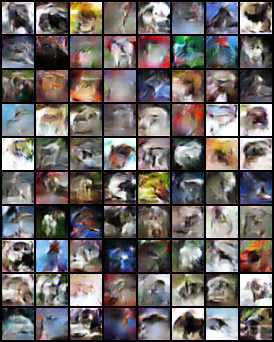
## 7. 青蛙
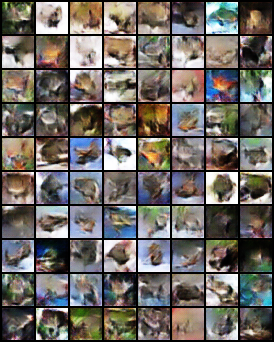
## 8. 马
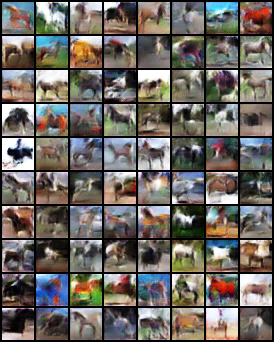
## 9. 船
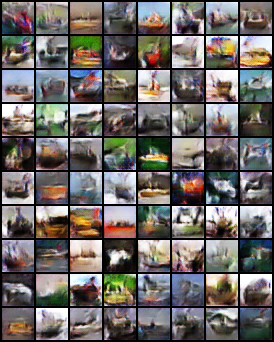
## 10. 卡车
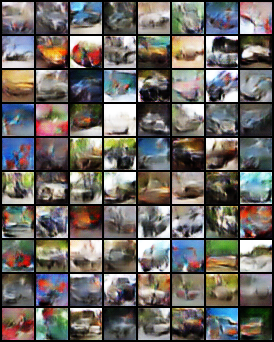


In [13]:
for i in range(10):
    c = torch.randint(low = 0, high = 9, size = (num_img,)).to(device)
    c = c * 0 + i
    print(c)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 